In [1]:
options(warn = -1, tibble.width = Inf)

rm(list = ls())
gc(reset = TRUE)

library(tidyverse)
library(data.table)

setwd("C:\\Users\\UOS\\Desktop\\dacon\\data")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,508985,27.2,1093324,58.4,508985,27.2
Vcells,974556,7.5,8388608,64.0,974556,7.5


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.1.0     √ purrr   0.2.5
√ tibble  1.4.2     √ dplyr   0.7.8
√ tidyr   0.8.2     √ stringr 1.3.1
√ readr   1.2.1     √ forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose



In [4]:
pre_tmp <- fread('Pre_Season_Batter.csv', encoding = 'UTF-8') %>% as.tibble

rsb <- fread('Regular_Season_Batter.csv', encoding = 'UTF-8') %>% as.tibble

dbd_tmp <- fread('Regular_Season_Batter_Day_by_Day.csv', encoding = 'UTF-8') %>% as.tibble

In [5]:
pre = pre_tmp %>% 
  mutate(`1B` = H - `2B` - `3B` - `HR`) %>%
  select(batter_id:year, AB:GDP, `1B`, -TB)

dbd = dbd_tmp %>%
  mutate(`1B` = H - `2B` - `3B` - `HR`) %>% 
  select(batter_id, batter_name, year, date, opposing_team, avg1, AB, R, H, `1B`, everything())

criterion = 7.17

dbd_fh = dbd %>% filter(date <= criterion) # 전반기 데이터

dbd_sh = dbd %>% filter(date > criterion) # 후반기 데이터

rsb_fh_x = dbd_fh %>% group_by(batter_id, batter_name, year) %>% summarise_at(colnames(.)[c(7:20)], funs(sum)) %>% ungroup()

rsb_fh_y = dbd_fh %>% group_by(batter_id, batter_name, year) %>% 
  summarise(OBP = (sum(H) + sum(BB) + sum(HBP))/(sum(AB) + sum(BB) + sum(HBP)), SLG = (sum(`1B`) + sum(`2B`)*2 + sum(`3B`)*3 + sum(HR)*4)/sum(AB), AB = sum(AB)) %>% 
  mutate(OPS = OBP + SLG) %>% ungroup()

rsb_sh_x = dbd_sh %>% group_by(batter_id, batter_name, year) %>% summarise_at(colnames(.)[7:20], funs(sum)) %>% ungroup()

rsb_sh_y = dbd_sh %>% group_by(batter_id, batter_name, year) %>% 
  summarise(OBP = (sum(H) + sum(BB) + sum(HBP))/(sum(AB) + sum(BB) + sum(HBP)), SLG = (sum(`1B`) + sum(`2B`)*2 + sum(`3B`)*3 + sum(HR)*4)/sum(AB), AB = sum(AB)) %>% 
  mutate(OPS = OBP + SLG) %>% ungroup()

rsb_OPS <- rsb %>% select(batter_id, year, OPS)

rsb_fh_OPS <- rsb_fh_y %>% select(batter_id, year, OPS)

colnames(rsb_fh_OPS) <- c('batter_id', 'year', 'F_OPS')

rsb_sh_OPS <- rsb_sh_y %>% select(batter_id, year, OPS)

colnames(rsb_sh_OPS) <- c('batter_id', 'year', 'S_OPS')

rsb_OPS <- rsb_OPS %>% left_join(rsb_fh_OPS, by = c('batter_id', 'year'))

rsb_OPS <- rsb_OPS %>% left_join(rsb_sh_OPS, by = c('batter_id', 'year'))

tmp_data <- rsb_OPS %>% gather(key = 'season', value = 'season_OPS', -batter_id, -year)

### 2016 ~ 2018년 전체, 전반기 OPS 비교 그래프

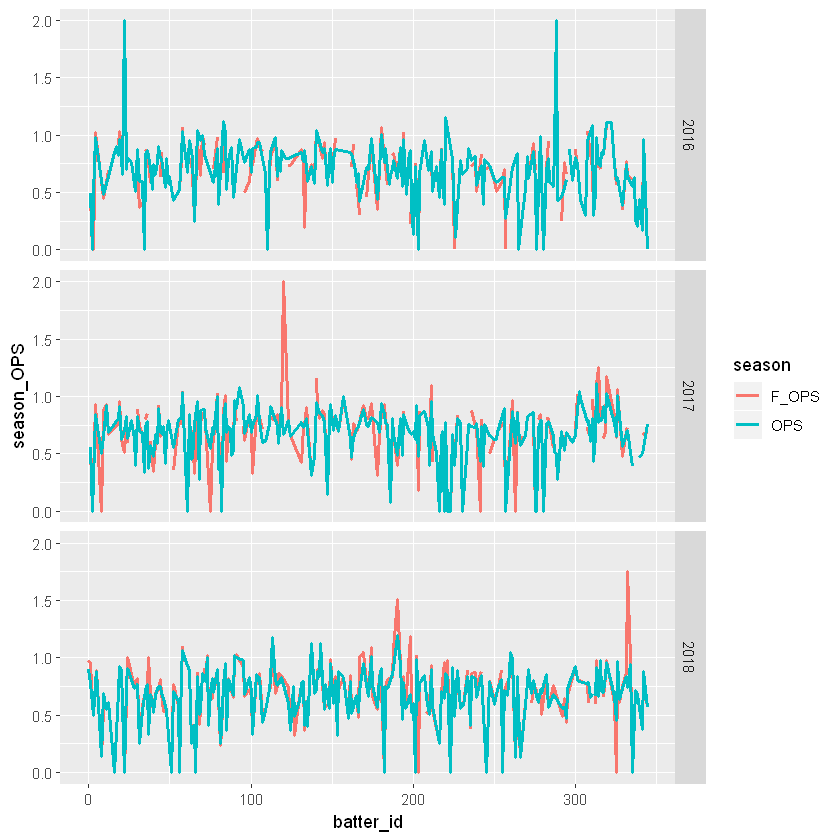

In [6]:
ggplot(tmp_data %>% filter((year %in% c(2016:2018)) & (season %in% c('OPS', 'F_OPS')))) + 
  geom_line(aes(x = batter_id, y = season_OPS, col = season), size = 1) +
  facet_grid(year ~.)

### 붉은색이 시즌 초반 OPS, 푸른색이 시즌 전체 OPS